# Variational Autoencoder (VAE)

In [1]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

In [2]:
train_dataset = MNIST(root='../datasets/', transform=transforms.ToTensor(), train=True, download=True)
val_dataset = MNIST(root='../datasets/', transform=transforms.ToTensor(), train=False, download=False)

In [3]:
assert torch.cuda.is_available()

In [4]:
# Training Parameters
BATCH_SIZE = 64
LR = 0.0001
NUM_EPOCHS = 30
DEVICE = torch.device('cuda')

In [5]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=False)

In [6]:
class VAE(nn.Module):
    def __init__(self, num_latent):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
            nn.Flatten(),
        )
        
        self.mu = nn.Linear(in_features=1600, out_features=num_latent)
        self.log_var = nn.Linear(in_features=1600, out_features=num_latent)
        
        self.decoder = nn.Sequential(
            nn.Linear(in_features=num_latent, out_features=1600),
            nn.Unflatten(1, (64, 5, 5)),
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        x = self.encoder(x)
        mu, sigma = self.mu(x), torch.exp(self.log_var(x) / 2)
        epsilon = torch.randn_like(mu, device=DEVICE)
        x = mu + sigma * epsilon
        x = self.decoder(x)
        return x, mu, sigma

In [7]:
# test input and output shapes
vae = VAE(20).to(DEVICE)
batch, _ = next(iter(train_dataloader))
batch = batch.to(DEVICE)
print(batch.shape)
x, mu, sigma = vae(batch)
print(x.shape, mu.shape, sigma.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28]) torch.Size([64, 20]) torch.Size([64, 20])


In [8]:
def train(num_epochs, train_dataloader, model, criterion, optimizer):
    history = {"reconstruction_loss": [], "kl_loss": [], "full_loss": []}
    model.to(DEVICE)
    for epoch in range(num_epochs):
        num_batches = 0
        history["reconstruction_loss"] = []
        history["kl_loss"] = []
        history["full_loss"] = []

        for batch_idx, (features, _) in enumerate(train_dataloader):
            model.train()
            num_batches+=1
            
            features = features.to(DEVICE)
            
            # Forward Pass
            output, mu, sigma = model(features)
            
            # Calculate Loss
            
            #RECONSTRUCTION LOSS
            reconstruction_loss = criterion(output, features)
            reconstruction_loss = reconstruction_loss.sum((1,2,3))
            reconstruction_loss = reconstruction_loss.mean()
            
            history["reconstruction_loss"].append(reconstruction_loss.cpu().item())
            
            #KL LOSS
            kl_loss = -0.5 * (1+ (sigma**2).log() - mu**2 - sigma**2).sum(dim=1)
            kl_loss = kl_loss.mean()
            
            history["kl_loss"].append(kl_loss.cpu().item())

            # FULL LOSS
            loss = reconstruction_loss + kl_loss
            
            history["full_loss"].append(loss.cpu().item())


            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        reconstruction_loss, kl_loss, full_loss = sum(history["reconstruction_loss"])/num_batches, \
                                                 sum(history["kl_loss"])/num_batches, \
                                                 sum(history["full_loss"])/num_batches

        print(f'Epoch: {epoch+1:>2}/{num_epochs} | Reconstruction Loss: {reconstruction_loss:.5f} | KL Loss: {kl_loss:.5f} | Full Loss: {full_loss:.5f}')
        
    return history          


In [9]:
vae = VAE(20)
optimizer = optim.Adam(vae.parameters(), lr=LR)
criterion = nn.MSELoss(reduction='none')

In [10]:
history = train(NUM_EPOCHS, train_dataloader, vae, criterion, optimizer)

Epoch:  1/30 | Reconstruction Loss: 71.65979 | KL Loss: 6.99413 | Full Loss: 78.65392
Epoch:  2/30 | Reconstruction Loss: 29.89784 | KL Loss: 11.75538 | Full Loss: 41.65322
Epoch:  3/30 | Reconstruction Loss: 23.30119 | KL Loss: 12.44067 | Full Loss: 35.74187
Epoch:  4/30 | Reconstruction Loss: 21.45647 | KL Loss: 12.49721 | Full Loss: 33.95368
Epoch:  5/30 | Reconstruction Loss: 20.46174 | KL Loss: 12.57142 | Full Loss: 33.03316
Epoch:  6/30 | Reconstruction Loss: 19.83186 | KL Loss: 12.62228 | Full Loss: 32.45414
Epoch:  7/30 | Reconstruction Loss: 19.34268 | KL Loss: 12.67719 | Full Loss: 32.01987
Epoch:  8/30 | Reconstruction Loss: 18.97952 | KL Loss: 12.71279 | Full Loss: 31.69231
Epoch:  9/30 | Reconstruction Loss: 18.68716 | KL Loss: 12.75092 | Full Loss: 31.43808
Epoch: 10/30 | Reconstruction Loss: 18.43620 | KL Loss: 12.78319 | Full Loss: 31.21938
Epoch: 11/30 | Reconstruction Loss: 18.23710 | KL Loss: 12.81677 | Full Loss: 31.05387
Epoch: 12/30 | Reconstruction Loss: 18.05697

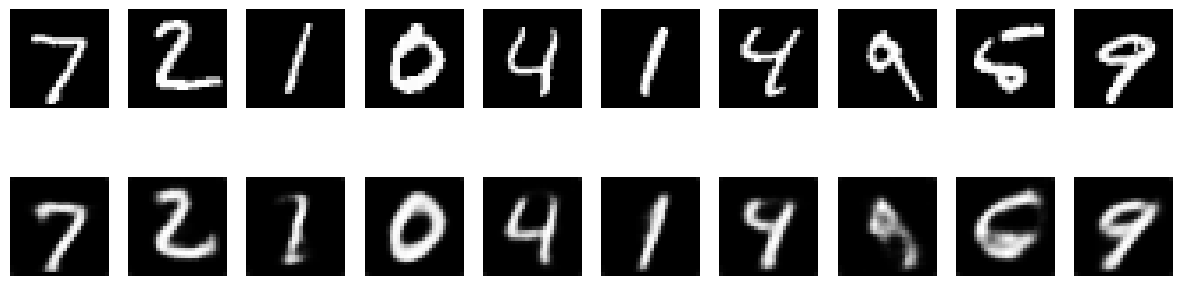

In [11]:
# draw original and reconstructed images
batch, _ = next(iter(val_dataloader))
batch = batch[:10, ...]
fig = plt.figure(figsize=(15, 4))

with torch.inference_mode():
    for i, img in enumerate(batch):
        fig.add_subplot(2, 10, i+1)
        orig_img = img.numpy()[0]
        plt.imshow(orig_img, cmap="gray")
        plt.axis('off')
        
        fig.add_subplot(2, 10, i+1+10)
        img = img.unsqueeze(0).to(DEVICE)
        rec_img, _, _ = vae(img)
        rec_img = rec_img.squeeze().cpu().numpy()
        plt.imshow(rec_img, cmap="gray")
        plt.axis('off')

    plt.show()